In [1]:
%matplotlib inline

In [2]:
style_img_path = "./data/backup_images/X-23 007-011.jpg"
content_img_path = "./data/content/Ben Reilly - Scarlet Spider (2017-) 016-010.jpg"
style_transfer_output_path = "./output/out.png"

# test_data_path = '/home/test/Documents/express_recognition/data/icdar2015/test2015'
test_data_path = './data/content'
checkpoint_path = './checkpoints_total/model_220.pth'
output_dir_box = './textresult/box'
output_dir_txt = './textresult/txt'
output_dir_pic = './textresult/pic'
 
mask_path = './textresult/txt/Ben Reilly - Scarlet Spider (2017-) 016-010.txt'
final_output_path = "./output/final.png"

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# desired size of the output image
imsize = 1024 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(style_img_path)
content_img = image_loader(content_img_path)
print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 1574, 1024])
torch.Size([1, 3, 1574, 1024])


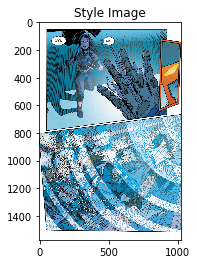

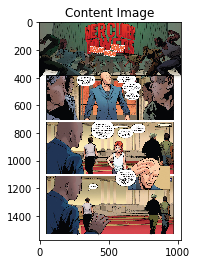

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [12]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

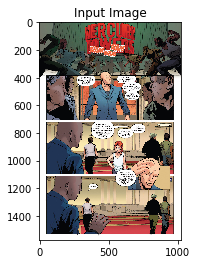

In [13]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [14]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [15]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 275.188690 Content Loss: 29.780903

run [100]:
Style Loss : 74.150650 Content Loss: 30.087229

run [150]:
Style Loss : 32.390366 Content Loss: 29.516430

run [200]:
Style Loss : 19.462372 Content Loss: 27.472021

run [250]:
Style Loss : 14.233673 Content Loss: 25.294483

run [300]:
Style Loss : 10.184727 Content Loss: 23.630341



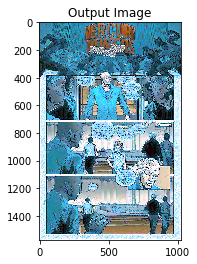

In [16]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [17]:
import torchvision.utils as utils
utils.save_image(output, style_transfer_output_path)

## EAST text detection

In [18]:
import cv2
import time
import math
import os 
import numpy as np

import locality_aware_nms as nms_locality
# import lanms

import torch
import model
from data_utils import restore_rectangle
from torch.autograd import Variable


import model


def rotate(box_List,image):
	#xuan zhuan tu pian

	n=len(box_List)
	c=0;
	angle=0
	for i in range(n):
		box=box_List[i]
		y1 = min(box[0][1], box[1][1], box[2][1], box[3][1])
		y2 = max(box[0][1], box[1][1], box[2][1], box[3][1])
		x1 = min(box[0][0], box[1][0], box[2][0], box[3][0])
		x2 = max(box[0][0], box[1][0], box[2][0], box[3][0])
		for j in range(4):
			if(box[j][1]==y2):
				k1=j
		for j in range(4):
			if(box[j][0]==x2 and j!=k1):
				k2=j
		c=(box[k1][0]-box[k2][0])*1.0/(box[k1][1]-box[k2][1])
		if(c<0):
			c=-c
		if(c>1):
			c=1.0/c
		angle=math.atan(c)+angle
	angle=angle/n
	(h, w) = image.shape[:2]
	center = (w / 2, h / 2)
	scale=1
	M = cv2.getRotationMatrix2D(center,angle, scale)
	image_new = cv2.warpAffine(image, M, (w, h))
	return image_new

def get_images():
	'''
	find image files in test data path
	:return: list of files found
	'''
	files = []
	exts = ['jpg', 'png', 'jpeg', 'JPG']
	for parent, dirnames, filenames in os.walk(test_data_path):
		for filename in filenames:
			for ext in exts:
				if filename.endswith(ext):
					files.append(os.path.join(parent, filename))
					break
	# print('Find {} images'.format(len(files)))
	return files

def resize_image(im, max_side_len=2400):
	'''
	resize image to a size multiple of 32 which is required by the network
	:param im: the resized image
	:param max_side_len: limit of max image size to avoid out of memory in gpu
	:return: the resized image and the resize ratio
	'''
	h, w, _ = im.shape

	resize_w = w
	resize_h = h

	# limit the max side
	if max(resize_h, resize_w) > max_side_len:
		ratio = float(max_side_len) / resize_h if resize_h > resize_w else float(max_side_len) / resize_w
	else:
		ratio = 1.
	resize_h = int(resize_h * ratio)
	resize_w = int(resize_w * ratio)

	resize_h = resize_h if resize_h % 32 == 0 else (resize_h // 32 - 1) * 32
	resize_w = resize_w if resize_w % 32 == 0 else (resize_w // 32 - 1) * 32
	im = cv2.resize(im, (int(resize_w), int(resize_h)))

	ratio_h = resize_h / float(h)
	ratio_w = resize_w / float(w)

	return im, (ratio_h, ratio_w)

def detect(score_map, geo_map, timer, score_map_thresh=0.8, box_thresh=0.1, nms_thres=0.2):
	'''
	restore text boxes from score map and geo map
	:param score_map:
	:param geo_map:
	:param timer:
	:param score_map_thresh: threshhold for score map
	:param box_thresh: threshhold for boxes
	:param nms_thres: threshold for nms
	:return:
	'''
	
	if len(score_map.shape) == 4:
		score_map = score_map[0, :, :, 0]
		geo_map = geo_map[0, :, :, ]
	# filter the score map
	xy_text = np.argwhere(score_map > score_map_thresh)
	# sort the text boxes via the y axis
	xy_text = xy_text[np.argsort(xy_text[:, 0])]
	# restore
	start = time.time()
	text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
	# print('{} text boxes before nms'.format(text_box_restored.shape[0]))
	boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
	boxes[:, :8] = text_box_restored.reshape((-1, 8))
	boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
	timer['restore'] = time.time() - start
	# nms part
	start = time.time()
	boxes = nms_locality.nms_locality(boxes.astype(np.float64), nms_thres)
# 	boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thres)
	timer['nms'] = time.time() - start

	if boxes.shape[0] == 0:
		return None, timer

	# here we filter some low score boxes by the average score map, this is different from the orginal paper
	for i, box in enumerate(boxes):
		mask = np.zeros_like(score_map, dtype=np.uint8)
		cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32) // 4, 1)
		boxes[i, 8] = cv2.mean(score_map, mask)[0]
	boxes = boxes[boxes[:, 8] > box_thresh]

	return boxes, timer

def sort_poly(p):
	min_axis = np.argmin(np.sum(p, axis=1))
	p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
	if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
		return p
	else:
		return p[[0, 3, 2, 1]]

def change_box(box_List):
	n=len(box_List)
	for i in range(n):
		box=box_List[i]
		y1 = min(box[0][1], box[1][1], box[2][1], box[3][1])
		y2 = max(box[0][1], box[1][1], box[2][1], box[3][1])
		x1 = min(box[0][0], box[1][0], box[2][0], box[3][0])
		x2 = max(box[0][0], box[1][0], box[2][0], box[3][0])
		box[0][1]=y1
		box[0][0]=x1
		box[1][1]=y1
		box[1][0]=x2
		box[3][1]=y2
		box[3][0]=x1
		box[2][1]=y2
		box[2][0]=x2
		box_List[i]=box
	return box_List

def save_box(box_List,image,img_path):
	n=len(box_List)
	box_final = []
	for i in range(n):
		box=box_List[i]
		y1_0 = int(min(box[0][1], box[1][1], box[2][1], box[3][1]))
		y2_0 = int(max(box[0][1], box[1][1], box[2][1], box[3][1]))
		x1_0 = int(min(box[0][0], box[1][0], box[2][0], box[3][0]))
		x2_0 = int(max(box[0][0], box[1][0], box[2][0], box[3][0]))
		y1 = max(int(y1_0 - 0.1 * (y2_0 - y1_0)), 0)
		y2 = min(int(y2_0 + 0.1 * (y2_0 - y1_0)), image.shape[0] - 1)
		x1 = max(int(x1_0 - 0.25 * (x2_0 - x1_0)), 0)
		x2 = min(int(x2_0 + 0.25 * (x2_0 - x1_0)), image.shape[1] - 1)
		image_new=image[y1:y2,x1:x2]

		# # 图像处理
		gray_2 = image_new[:,:,0]
		gradX = cv2.Sobel(gray_2, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
		gradY = cv2.Sobel(gray_2, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
		blurred = cv2.blur(gradX, (2, 2))
		(_, thresh) = cv2.threshold(blurred, 160, 255, cv2.THRESH_BINARY)
		# closed = cv2.erode(thresh, None, iterations = 1)
		# closed = cv2.dilate(closed, None, iterations = 1)
		closed = thresh
		x_plus = []
		x_left = 1
		x_right = closed.shape[1]
		for jj in range(0, closed.shape[1]):
			plus = 0
			for ii in range(0, closed.shape[0]):
				plus = plus + closed[ii][jj]
			x_plus.append(plus)
		
		for jj in range(0, int(closed.shape[1] * 0.5 - 1)):
			if(x_plus[jj] > 0.4 * max(x_plus)):
				x_left = max(jj - 5, 0)
				break
		for ii in range(closed.shape[1] - 1, int(closed.shape[1] * 0.5 + 1), -1):
			if(x_plus[ii] > 0.4 * max(x_plus)):
				x_right = min(ii + 5, closed.shape[1] - 1)
				break
		
		image_new = image_new[:, x_left:x_right]
		cv2.imwrite("." + img_path.split(".")[1]+'_'+str(i)+".jpg", image_new)
		box[0][1]=y1
		box[0][0]=x1 + x_left
		box[1][1]=y1
		box[1][0]=x1 + x_right
		box[3][1]=y2
		box[3][0]=x1 + x_left
		box[2][1]=y2
		box[2][0]=x1 + x_right
		box_List[i]=box
	return box_List

East_model = model.East()
East_model = East_model.eval()
East_model = East_model.cuda()

East_model.load_state_dict(torch.load(checkpoint_path))

def predict(argv=None):
	
    try:
        os.makedirs(output_dir_box)
        os.makedirs(output_dir_txt)
        os.makedirs(output_dir_pic)
    except OSError as e:
        if e.errno != 17:
            raise
    
    im_fn_list = get_images()
    start = time.time()
    for im_fn in im_fn_list:
        # print(im_fn)
        im = cv2.imread(im_fn)[:, :, ::-1]
        start_time = time.time()
        im_resized, (ratio_h, ratio_w) = resize_image(im)
        im_resized = im_resized.astype(np.float32)
        im_resized = Variable(torch.from_numpy(im_resized)).cuda()
        im_resized = im_resized.unsqueeze(0)
        im_resized = im_resized.permute(0, 3, 1, 2)
        
        timer = {'net': 0, 'restore': 0, 'nms': 0}
       
        score, geometry = East_model(im_resized)
        score = score.permute(0, 2, 3, 1)
        geometry = geometry.permute(0, 2, 3, 1)
        score = score.data.cpu().numpy()
        geometry = geometry.data.cpu().numpy()
        
        
        boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
        

        if boxes is not None:
            boxes = boxes[:, :8].reshape((-1, 4, 2))
            boxes[:, :, 0] /= ratio_w
            boxes[:, :, 1] /= ratio_h
        
        
        if boxes is not None:
            res_file = os.path.join(output_dir_txt, '{}.txt'.format(
                                os.path.basename(im_fn).split('.')[0]))
            
            with open(res_file, 'w') as f:
                for box in boxes:
                    
                    box = sort_poly(box.astype(np.int32))
                    if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
                        continue
                    f.write('{}, {}, {}, {}, {}, {}, {}, {}\r\n'.format(
                        box[0, 0], box[0, 1], box[1, 0], box[1, 1], box[2, 0], box[2, 1], box[3, 0], box[3, 1]))
                    cv2.polylines(im[:, :, ::-1], [box.astype(np.int32).reshape((-1, 1, 2))], True,
                                  color=(0, 0, 255), thickness=5)
             
        img_path = os.path.join(output_dir_pic, os.path.basename(im_fn))
        cv2.imwrite(img_path, im[:, :, ::-1])

    during = time.time() - start
    print('average :{:.6f}'.format(during / len(im_fn_list)))

# if __name__ == "__main__":
# 	predict()


In [19]:
predict()

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


average :0.358934


## merge the two result

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_mask(textfilepath, imgsize):
	with open(textfilepath, 'r') as f:
		polys = f.read()[:-1].split('\n')
		polys = [poly.split(', ') for poly in polys]
		polys = [np.array(poly, dtype=np.int32).reshape((-1, 1, 2)) for poly in polys]

	mask = np.zeros(imgsize, dtype=np.uint8)

	if len(polys) == 0:
		return mask

	cv2.fillPoly(mask, polys, color=255)
	mask = mask.astype(bool)
	# cv2.polylines(mask, polys, True, color=255, thickness=1)

	return mask

# if __name__ == '__main__':
style_img = cv2.imread(style_transfer_output_path)
print(style_img.shape)
img = cv2.imread(content_img_path)
img = cv2.resize(img,(style_img.shape[1], style_img.shape[0]))
m = get_mask(mask_path, img.shape[:2])
m = np.repeat(m[:, :, np.newaxis], 3, axis=2)
# temp = np.zeros(img.shape, dtype=np.uint8)
style_img[np.where(m == 1)] = img[np.where(m == 1)]
# 	plt.figure(figsize = (16,12))
# plt.imshow(temp)
cv2.imwrite(final_output_path, style_img)

(1574, 1024, 3)


True